# Machine Learning I - Practical I

Name: {Natsumi Omura}

Course: {Quantitative Data Science Methods}

This notebook provides you with the assignments and the overall code structure you need to complete the assignment. Each exercise indicates the total number of points allocated. There are also questions that you need to answer in text form. Please use full sentences and reasonably correct spelling/grammar.

Regarding submission & grading:

- Solutions can be uploaded to ILIAS until the indicated deadline. Please upload a copy of this notebook and a PDF version of it after you ran it.

- Please hand in your own solution. You are encouraged to discuss your code with classmates and help each other, but after that, please sit down for yourself and write your own code. 

- We will grade not only based on the outputs, but also look at the code. So please use comments make us understand what you intended to do :)

- For plots you create yourself, all axes must be labeled. 

- DO NOT IN ANY CASE change the function interfaces.

- If you are not familiar with python, then this may be of help. This is a colab notebook which is part of the Convolutional Neural Networks for Visual Recognition course (CS231n) in Stanford. It goes through some of the basic elements of Python and Numpy. You can run it directly in the browser without having Python installed:
    
    https://colab.research.google.com/github/cs231n/cs231n.github.io/blob/master/python-colab.ipynb#scrollTo=U1PvreR9L9eW  
    

- If you are not familiar with python, but used MATLAB before, check out this reference pages listing what you want to use as python equivalent of a certain MATLAB command:

    https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html
    
    http://www.eas.uccs.edu/~mwickert/ece5650/notes/NumPy2MATLAB.pdf
    
    http://mathesaurus.sourceforge.net/matlab-python-xref.pdf
    
    or, if you prefer to read a longer article, try: 
    
    https://realpython.com/matlab-vs-python/#learning-about-pythons-mathematical-libraries
    
    

In [331]:
%matplotlib notebook

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import stats
import copy
import pylab
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## The  dataset

The dataset consists of over 20.000 materials and lists their physical features. From these features, we want to learn how to predict the critical temperature, i.e. the temperature we need to cool the material to so it becomes superconductive. First load and familiarize yourself with the data set a bit.

In [332]:
data=pd.read_csv('superconduct_train.csv')
print(data.shape)

(21263, 82)


In [333]:
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


Because the dataset is rather large, we prepare a small subset of the data as training set, and another subset as test set. To make the computations reproducible, we set the random seed.

In [334]:
target_clm = 'critical_temp' # the critical temperature is our target variable
n_trainset = 200 # size of the training set
n_testset = 500 #size of the test set

In [335]:
# set random seed to make sure every test set is the same
np.random.seed(seed=1)

idx = np.arange(data.shape[0])
idx_shuffled = np.random.permutation(idx) # shuffle indices to split into training and test set

test_idx = idx_shuffled[:n_testset]
train_idx = idx_shuffled[n_testset:n_testset+n_trainset]
train_full_idx = idx_shuffled[n_testset:]

X_test = data.loc[test_idx, data.columns != target_clm].values
y_test = data.loc[test_idx, data.columns == target_clm].values
print('Test set shapes (X and y)', X_test.shape, y_test.shape)

X_train = data.loc[train_idx, data.columns != target_clm].values
y_train = data.loc[train_idx, data.columns == target_clm].values
print('Small training set shapes (X and y):',X_train.shape, y_train.shape)

X_train_full = data.loc[train_full_idx, data.columns != target_clm].values
y_train_full = data.loc[train_full_idx, data.columns == target_clm].values
print('Full training set shapes (X and y):',X_train_full.shape, y_train_full.shape)
type(X_train_full)

Test set shapes (X and y) (500, 81) (500, 1)
Small training set shapes (X and y): (200, 81) (200, 1)
Full training set shapes (X and y): (20763, 81) (20763, 1)


numpy.ndarray

## Task 1: Plot the dataset [5 pts]

To explore the dataset, use `X_train_full` and `y_train_full` for two descriptive plots:

* **Histogram** of the target variable. Use `plt.hist`.

* **Scatterplots** relating the target variable to one of the feature values. For this you will need 81 scatterplots. Arrange them in one big figure with 9x9 subplots. Use `plt.scatter`. You may need to adjust the marker size and the alpha blending value. 

<IPython.core.display.Javascript object>


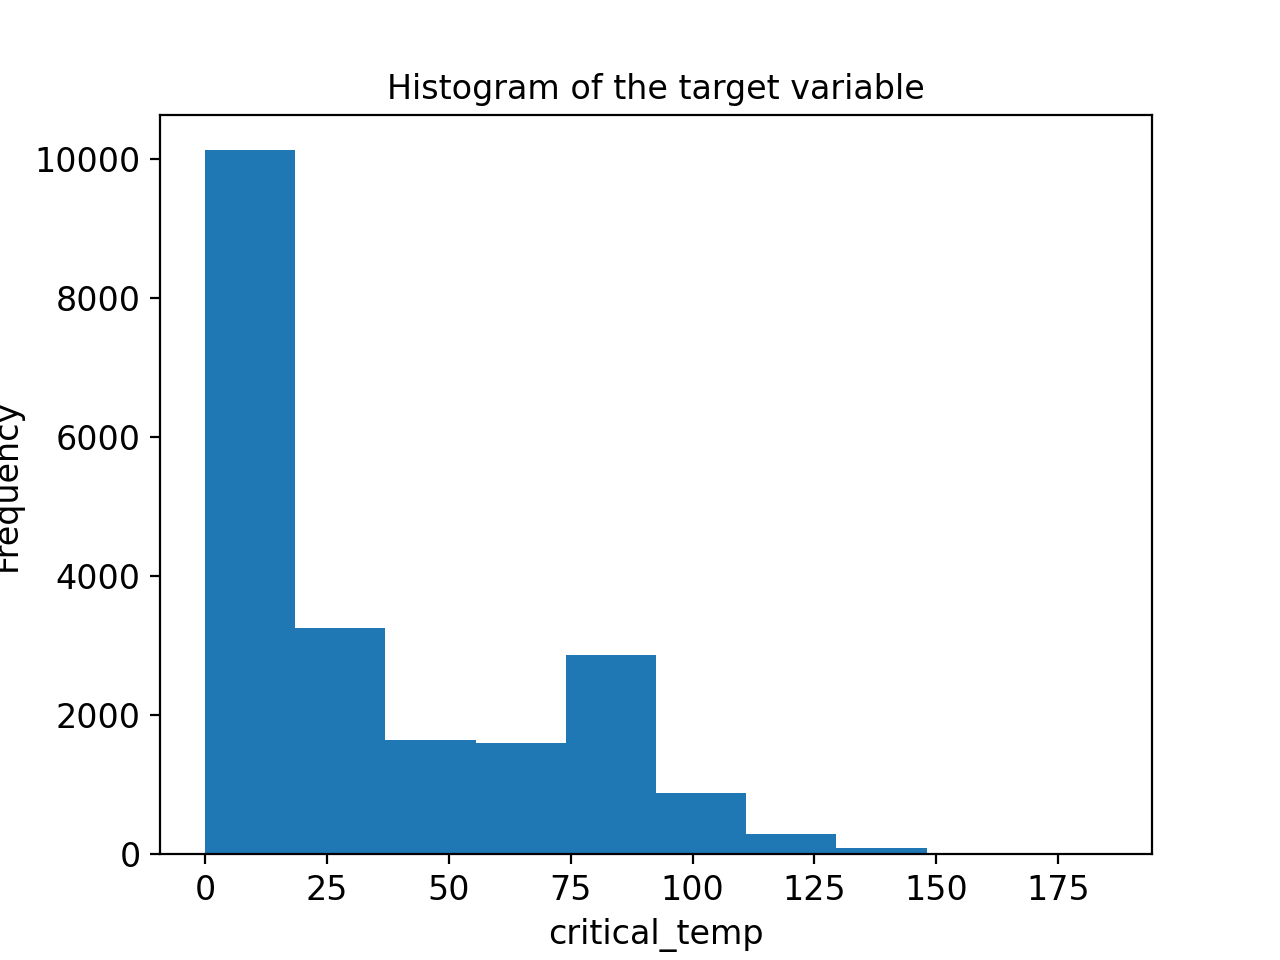

(array([1.0124e+04, 3.2610e+03, 1.6480e+03, 1.5970e+03, 2.8610e+03,
        8.8600e+02, 2.9200e+02, 9.3000e+01, 0.0000e+00, 1.0000e+00]),
 array([2.10000000e-04, 1.85001890e+01, 3.70001680e+01, 5.55001470e+01,
        7.40001260e+01, 9.25001050e+01, 1.11000084e+02, 1.29500063e+02,
        1.48000042e+02, 1.66500021e+02, 1.85000000e+02]),
 <BarContainer object of 10 artists>)

In [336]:
# Histogram of the target variable
plt.title("Histogram of the target variable", fontsize=12)  #  title
plt.xlabel("critical_temp", fontsize=12)            #  x axis name
plt.ylabel("Frequency", fontsize=12)      #  y axis name
plt.tick_params(labelsize = 12)  

plt.hist(y_train_full)

<IPython.core.display.Javascript object>


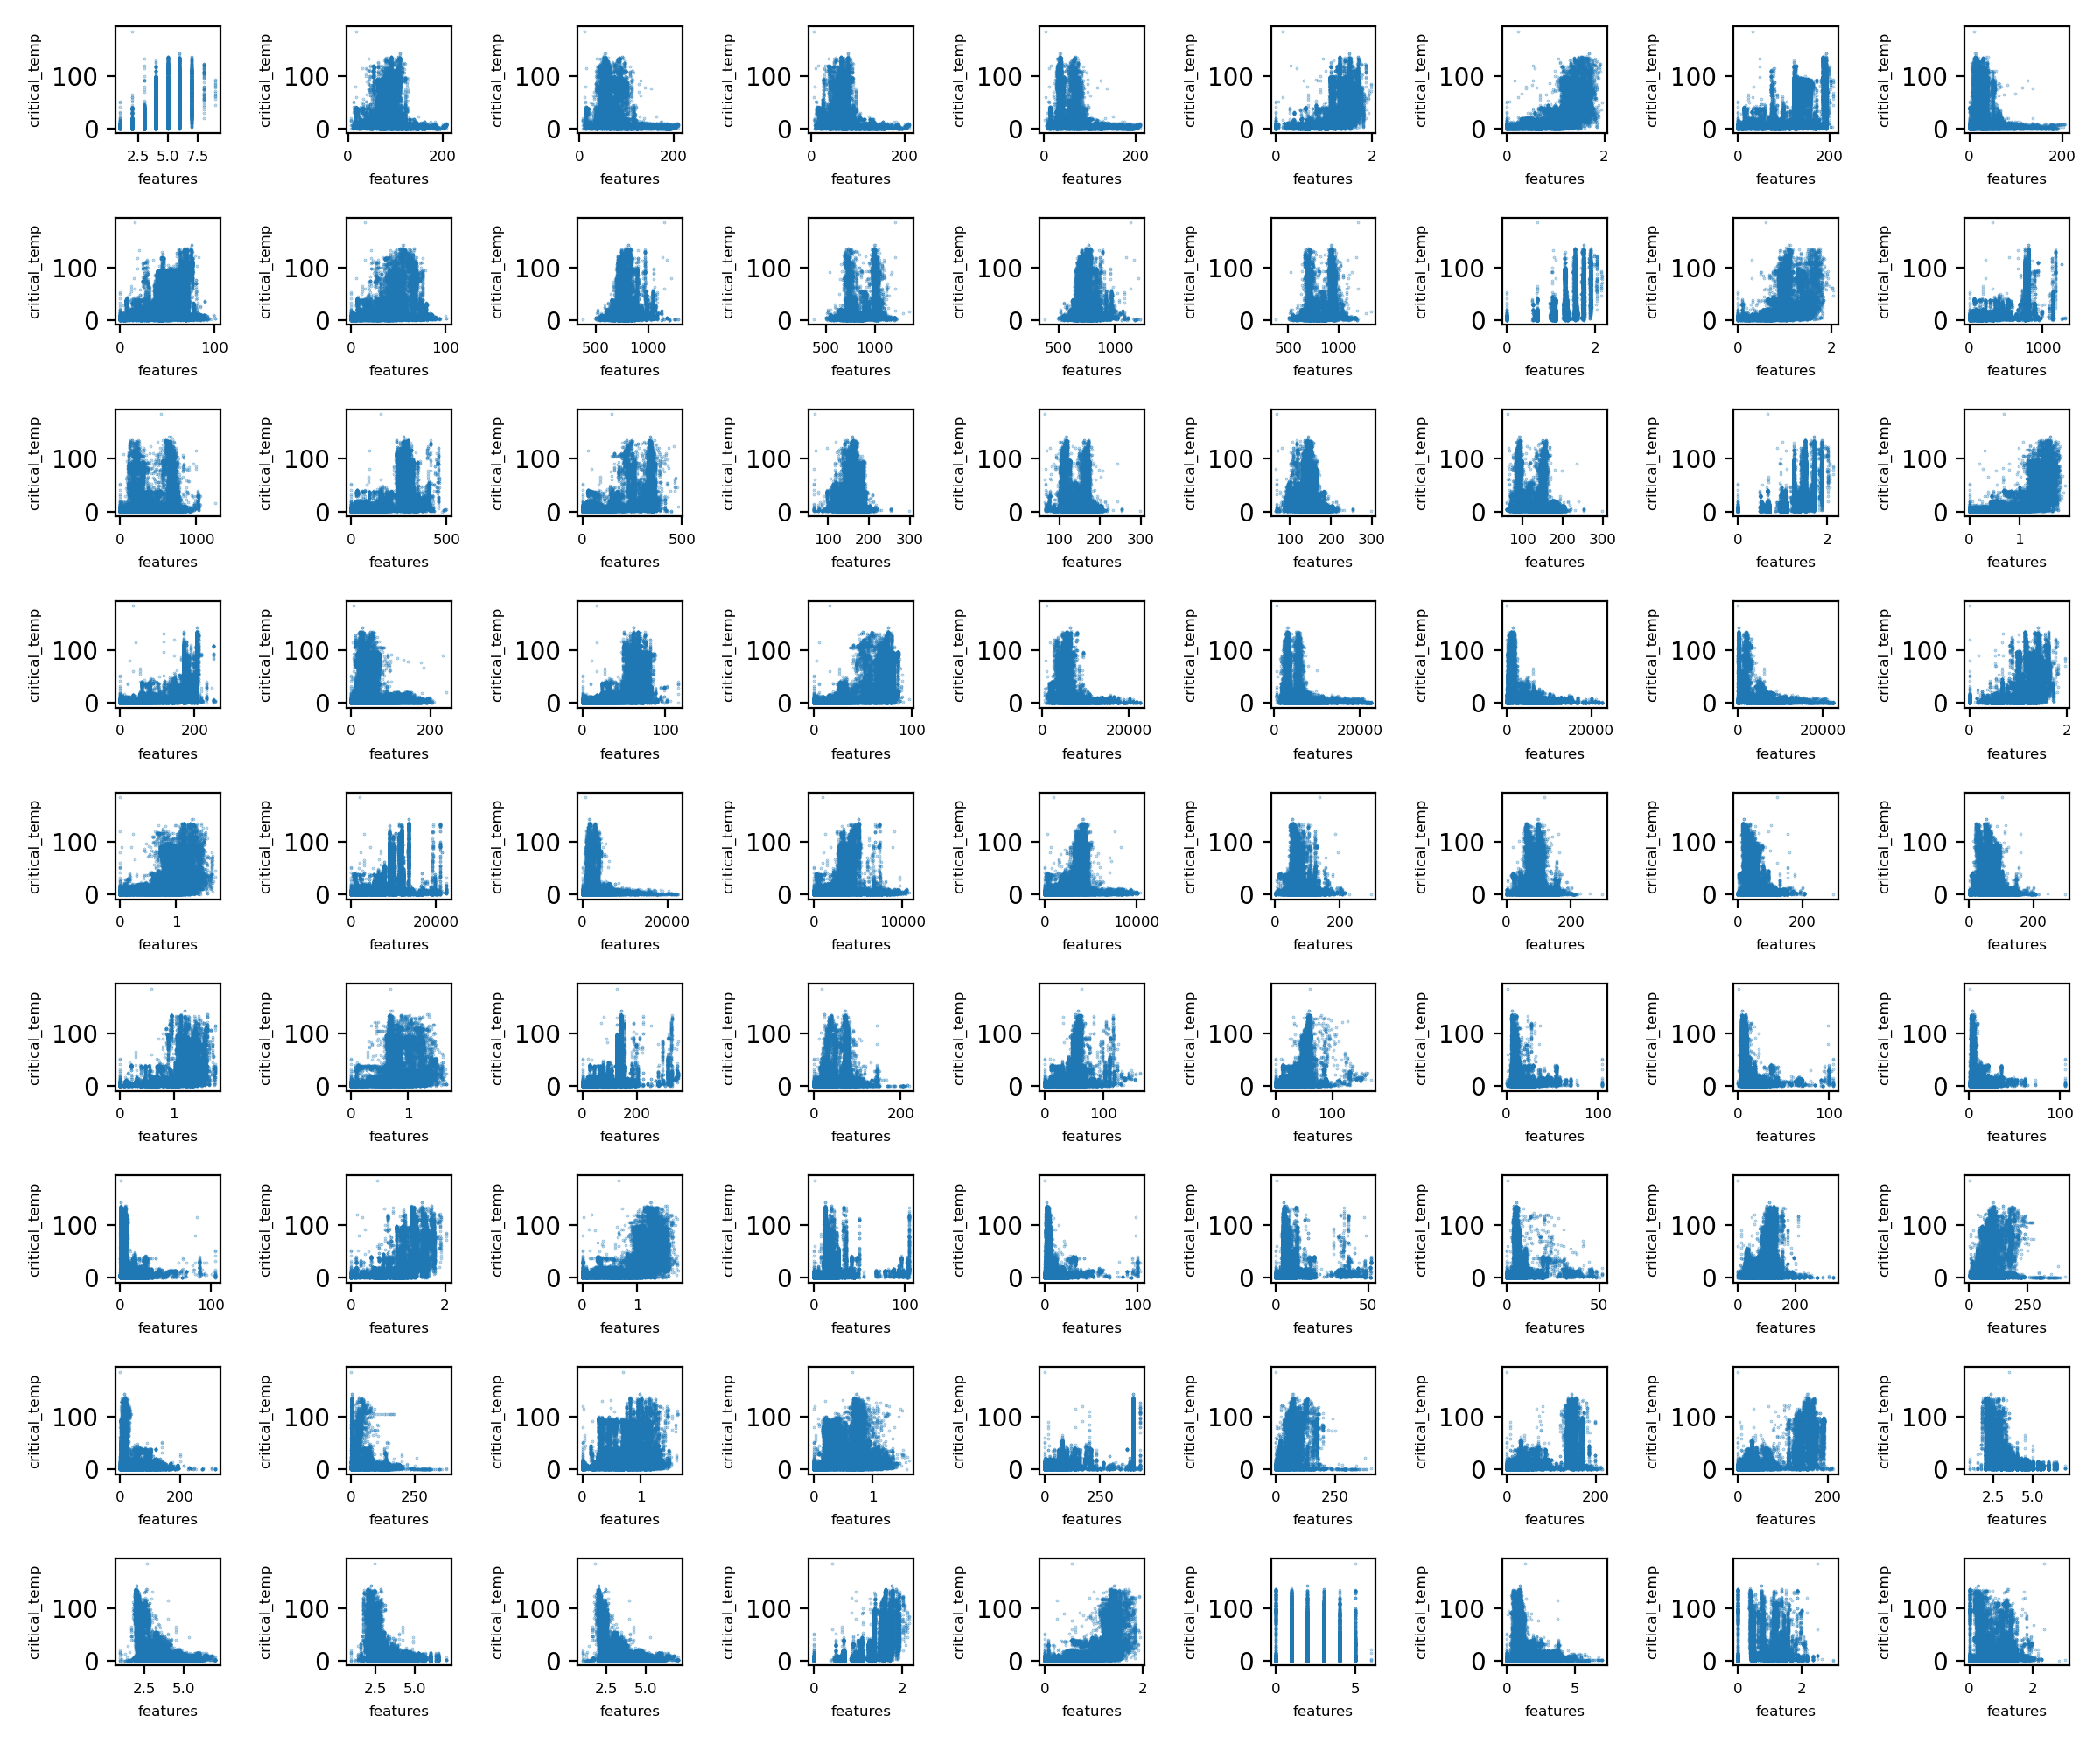

In [337]:
# Scatter plots of the target variable vs. features
i= 1
plt.figure(figsize=(12,10))
plt.xlabel("x axis")
data.columns
while i<82 :
    plt.subplot(9,9,i)
    plt.scatter(X_train_full[:, i-1], y_train_full, s=0.1, alpha=0.5)
    plt.tick_params(axis = 'x', labelsize = 6)
    plt.xlabel('features', fontsize=6)            #feature
    plt.ylabel("critical_temp", fontsize=6)  #target variable
    i += 1
plt.tight_layout()

In [289]:
data.columns[76]

'wtd_entropy_Valence'

Which material properties may be useful for predicting superconductivity? What other observations can you make?

When we see the above subplot (number of the rows, number of the columns), the following propertiies seem useful. This is because that they seem to have the positive correlations between each property and the target variables.
(0,0)'number_of_elements'
(0,5)'entropy_atomic_mass'
(0,6)'wtd_entropy_atomic_mass'
(0,7)'range_atomic_mass'
(1,0)'std_atomic_mass'
(1,1)'wtd_std_atomic_mass'
(1,6)'entropy_fie'
(1,7)'wtd_entropy_fie'
(2,2)'wtd_std_fie'
(2,7)'entropy_atomic_radius'
(3,0)'range_atomic_radius'
(3,3)'wtd_std_atomic_radius'
(3,8)'entropy_Density'
(4,0)'wtd_entropy_Density'
(5,0)'entropy_ElectronAffinity'
(5,1)'wtd_entropy_ElectronAffinity'
(6,1)'entropy_FusionHeat'
(6,2)'wtd_entropy_FusionHeat'
(7,6)'std_ThermalConductivity'
(7,7)'wtd_std_ThermalConductivity'
(8,3)'entropy_Valence'
(8,4)'wtd_entropy_Valence'
Ths other variable seem less useful than the above properties because some are located almost everywhere of the subplot, and some are scattered on the several vertical line.

## Task 2:  Implement your own OLS estimator [10 pts]

We want to use linear regression to predict the critical temperature. Implement the ordinary least squares estimator without regularization 'by hand':

$w = (X^TX)^{-1}X^Ty$

To make life a bit easier, we provide a function that can be used to plot regression results. In addition it computes the mean squared error and the squared correlation between the true and predicted values. 

In [338]:
from sklearn.linear_model import LinearRegression
def plot_regression_results(y_test,y_pred,weights):
    '''Produces three plots to analyze the results of linear regression:
        -True vs predicted
        -Raw residual histogram
        -Weight histogram
        
    Inputs:
        y_test: (n_observations,) numpy array with true values
        y_pred: (n_observations,) numpy array with predicted values
        weights: (n_weights) numpy array with regression weights'''
    
    print('MSE: ', mean_squared_error(y_test,y_pred))
    print('r^2: ', r2_score(y_test,y_pred))
    
    fig,ax = plt.subplots(1,3,figsize=(9,3))
    #predicted vs true
    ax[0].scatter(y_test,y_pred)
    ax[0].set_title('True vs. Predicted')
    ax[0].set_xlabel('True %s' % (target_clm))
    ax[0].set_ylabel('Predicted %s' % (target_clm))

    #residuals
    error = np.squeeze(np.array(y_test)) - np.squeeze(np.array(y_pred))
    ax[1].hist(np.array(error),bins=30)
    ax[1].set_title('Raw residuals')
    ax[1].set_xlabel('(true-predicted)')

    #weight histogram
    ax[2].hist(weights,bins=30)
    ax[2].set_title('weight histogram')

    plt.tight_layout()

As an example, we here show you how to use this function with random data. 

MSE:  2640.432578444892
r^2:  -1.108062856115481


<IPython.core.display.Javascript object>


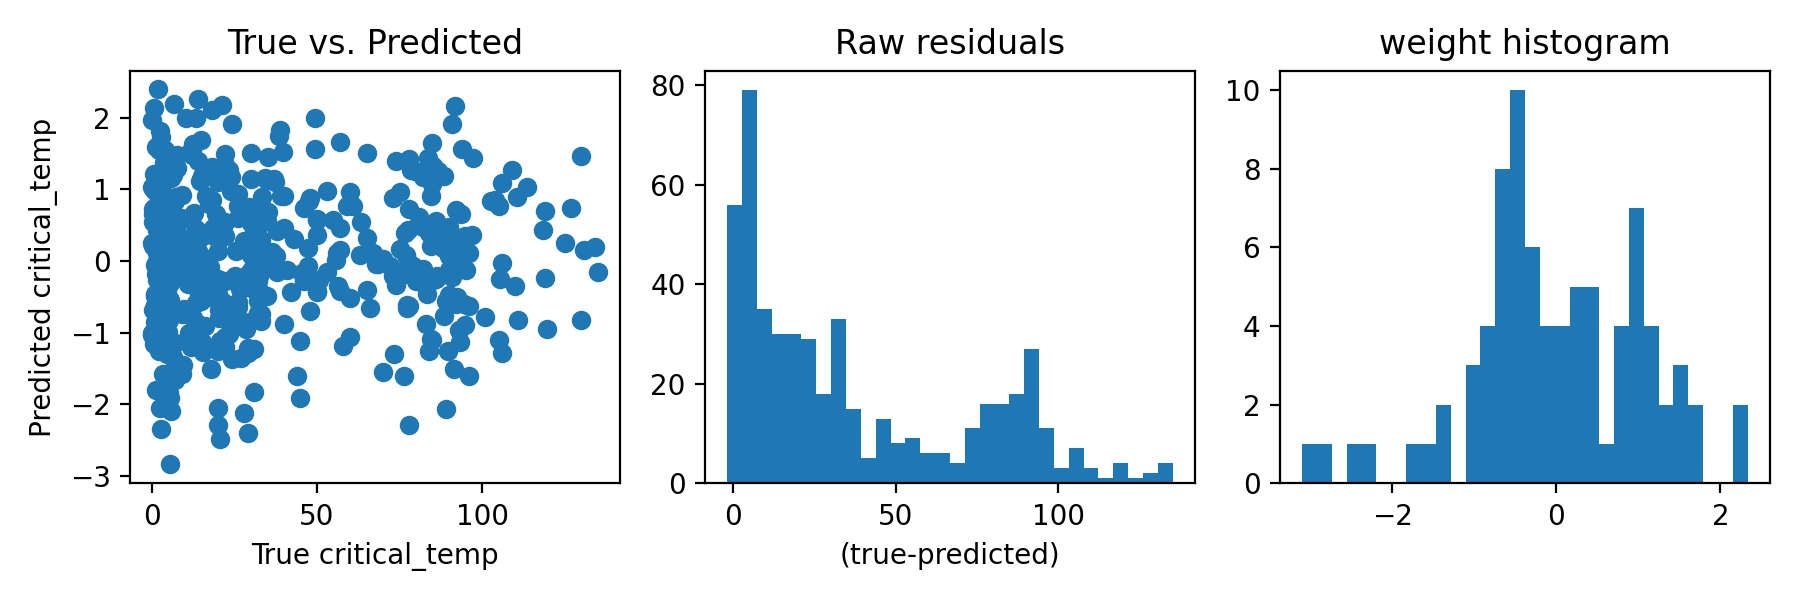

In [339]:
# weights is a vector of length 82: the first value is the intercept (beta0), then 81 coefficients
weights = np.random.randn(82)

# Model predictions on the test set
y_pred_test = np.random.randn(y_test.size)

plot_regression_results(y_test, y_pred_test, weights)

Implement OLS linear regression yourself. Use `X_train` and `y_train` for estimating the weights, and use `X_test` to compute test set predictions. `OLS_regression` is supposed to return those. Call our plotting function with the regession result to compute the MSE and $r^2$. You should get mean squared error of 599.7.

In [340]:
def OLS_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization on the training set and 
       returns weights and testset predictions.
    
       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set 
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         
       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set
         
       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.        
    
    '''
    X_train_1 = np.ones((X_train.shape[0], 1))
    X_test_1 = np.ones((X_test.shape[0], 1))
    X_train = np.append(X_train_1, X_train, axis=1)    # append the 1st column whose elements are all 1 to the X_test
    X_test = np.append(X_test_1, X_test, axis=1)     ## append the 1st column whose elements are all 1 to the X_train
    weights = np.dot(np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), X_train.T), y_train) ##excutes the matrix calculation.
    y_pred = X_test@weights
    return weights, y_pred

MSE:  599.7397625945957
r^2:  0.5211810643520391


<IPython.core.display.Javascript object>


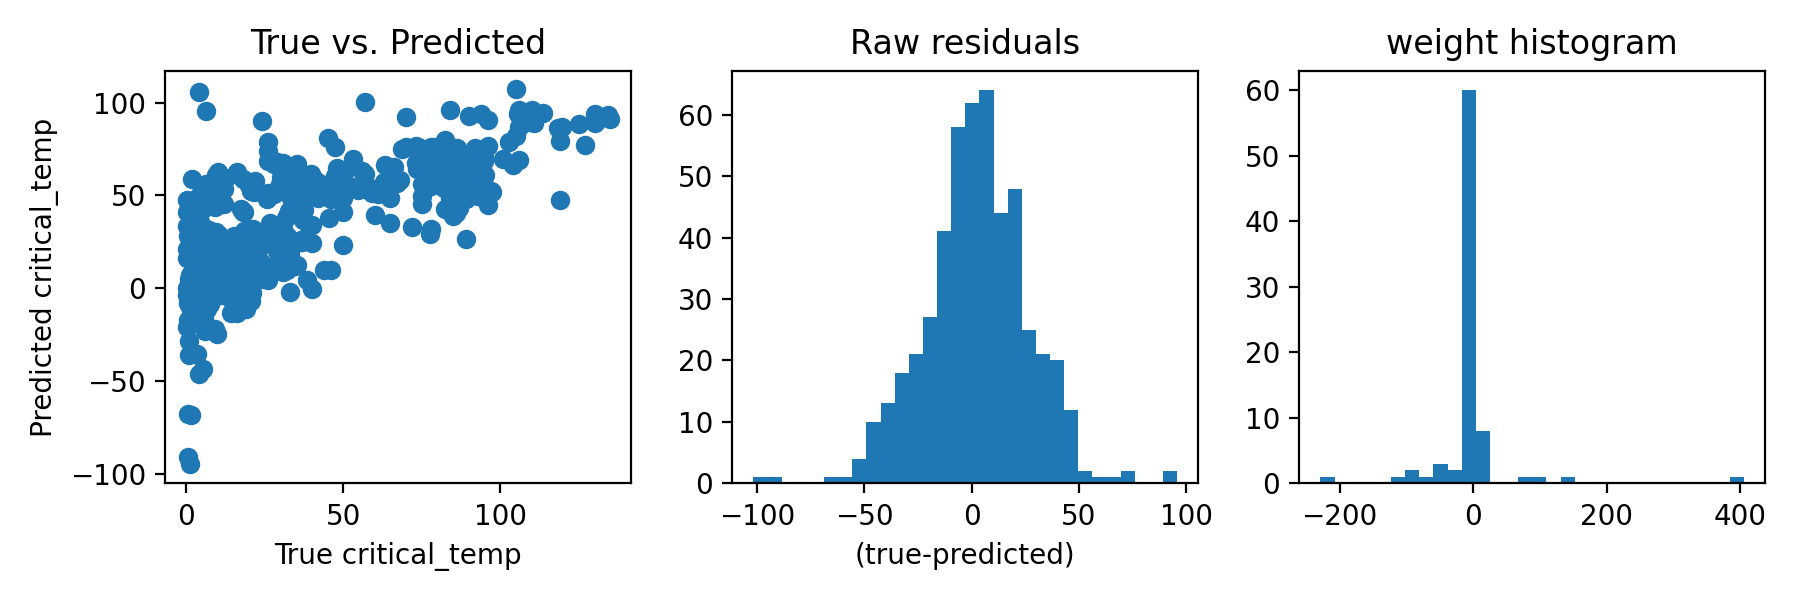

In [341]:
weights, y_pred = OLS_regression(X_test, X_train, y_train)
plot_regression_results(y_test, y_pred, weights)

What do you observe? Is the linear regression model good?

From the outcome, coefficient of determination is 0.5211810643520391. This number is not very close to 1, so we cannot say this fitting is good.
From the first plot(scattered graph), many points are not on the line which is y=x, so we cannot say this fitting is good. 
From the third plot(histogram), there are many(about 60) variables estimated to 0, so we cannot say this is a good model. We can consider to reduce the number of the variables, by putting some.
To conclude, the linear regression model isn't good.

## Task 3: Compare your implementation to sklearn [5 pts]

Now, familarize yourself with the sklearn library. In the section on linear models:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

you will find `sklearn.linear_model.LinearRegression`, the `sklearn` implementation of the OLS estimator. Use this sklearn class to implement OLS linear regression. Again obtain estimates of the weights on `X_train` and `y_train` and compute the MSE and $r^2$ on `X_test`.


In [343]:
clf = linear_model.LinearRegression()
def sklearn_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization using the sklearn library on the training set and 
       returns weights and testset predictions.
    
       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set 
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         
       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set
          
         
       Note:
         The sklearn library automatically takes care of adding a column for the offset.     
    
    '''
    
    # ADD YOUR CODE HERE
    reg = clf.fit(X_train, y_train, sample_weight=None)
    weights = np.append(reg.intercept_, reg.coef_)     # to consider the intercept part of the estimated weights.
    y_pred = reg.predict(X_test)
    return weights, y_pred

MSE:  599.7397626176332
r^2:  0.5211810643336465


<IPython.core.display.Javascript object>


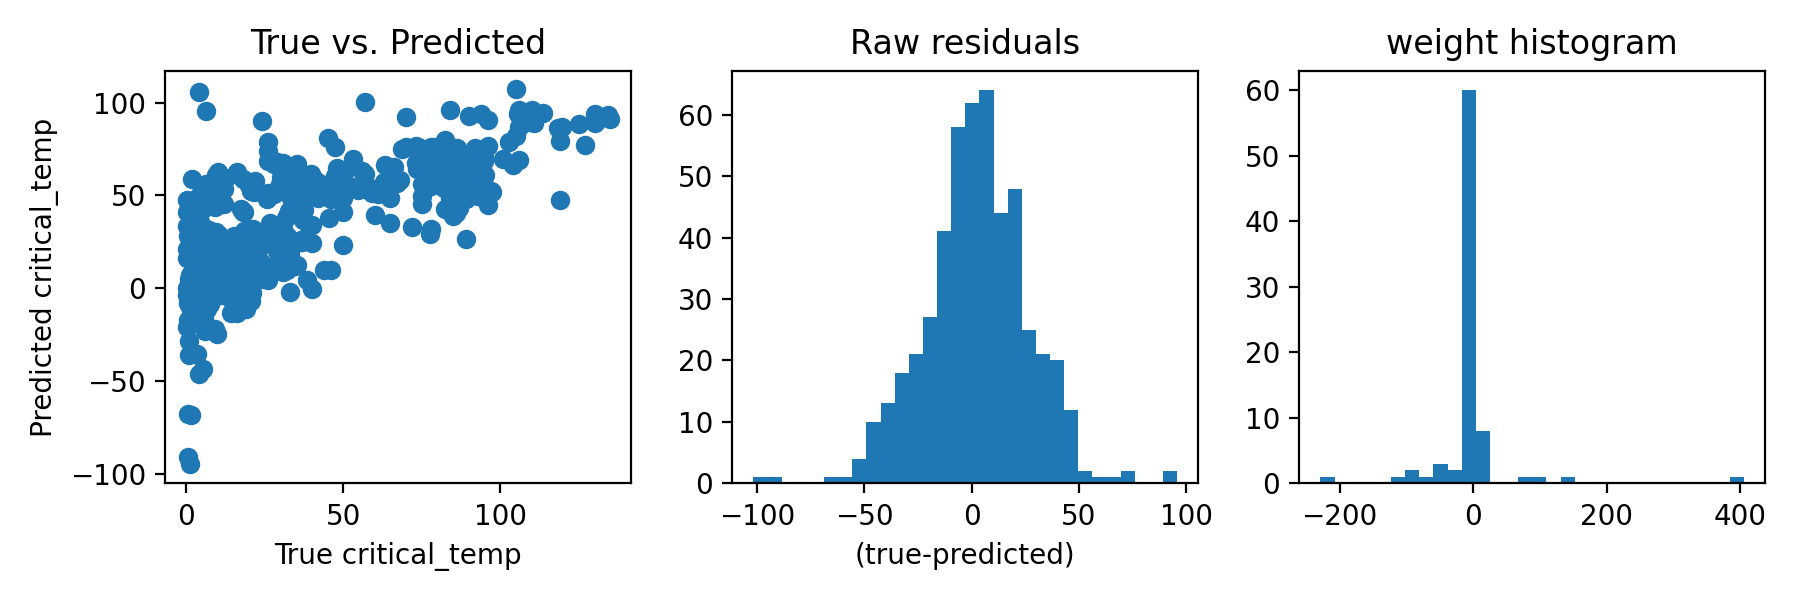

In [344]:
weights, y_pred = sklearn_regression(X_test, X_train, y_train)
plot_regression_results(y_test, y_pred, weights)

If you implemented everything correctly, the MSE is again 599.74.

Fit the model using the larger training set, `X_train_full` and `y_train_full`, and again evaluate on `X_test`.

MSE:  329.8607010410669
r^2:  0.7366465263178849


<IPython.core.display.Javascript object>


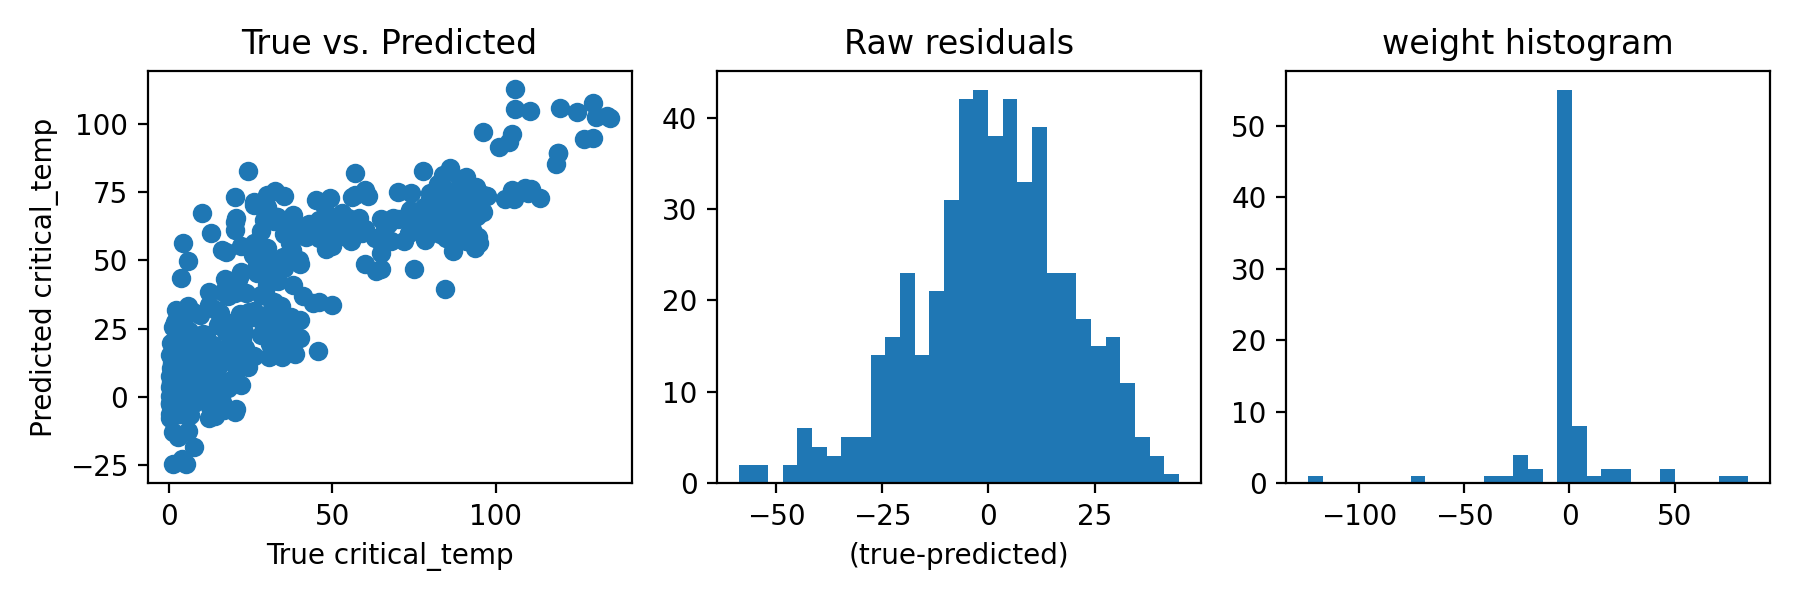

In [345]:
weights, y_pred = sklearn_regression(X_test, X_train_full, y_train_full)
plot_regression_results(y_test, y_pred, weights)

 How does test set performance change? What else changes?

About the MSE: previous MSE was 599.7397625945957 but this time is 329.8607010410669. Since MSE has decreased, we can say the model has improved.
About the r^2: previous r^2 was 0.5211810643520391 but this time is 0.7366465263178849. Since r^2 has become closer to 1.0, we can say the model has improved.
When we compare the first plot(scattered) of this model and that of the previous model, we can see more points of this model are on the line of y=x. Then we can say the fitting has improved.
To sum up, we can see test set performance has improved.

## Task 4: Regularization with ridge regression [15 pts]

We will now explore how a penalty term on the weights can improve the prediction quality for finite data sets. Implement the analytical solution of ridge regression 

$w = (X^TX + \alpha I_D)^{-1}X^Ty$


as a function that can take different values of $\alpha$, the regularization strength, as an input. In the lecture, this parameter was called $\lambda$, but this is a reserved keyword in Python.

In [346]:
def ridge_regression(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha 
       on the training set and returns weights and testset predictions.
    
       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set 
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength
         
       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set
          
       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.       
    
    '''
    X_train_1 = np.ones((X_train.shape[0], 1))
    X_test_1 = np.ones((X_test.shape[0], 1))
    # append the 1st column whose elements are all 1 to the X_test
    X_train = np.append(X_train_1, X_train, axis=1)  
    # append the 1st column whose elements are all 1 to the X_train
    X_test = np.append(X_test_1, X_test, axis=1)   
    ##excutes the matrix calculation.
    weights = np.dot(np.dot(np.linalg.inv(np.dot(X_train.T, X_train) + alpha * np.identity(82) ), X_train.T), y_train)
    y_pred = X_test@weights   
    return weights, y_pred

Now test a range of log-spaced $\alpha$s (~10-20), which cover several orders of magnitude, e.g. from 10^-7 to 10^7. 

* For each $\alpha$, you will get one model with one set of weights. 
* For each model, compute the error on the test set. 

Store both the errors and weights of all models for later use. You can use the function `mean_squared_error` from sklearn (imported above) to compute the MSE.


In [347]:
alphas = np.logspace(-7,7,100)
list_weights = np.empty((82, 100))
list_MSE = []

for i, alpha in enumerate(alphas):
    weights, y_pred = ridge_regression(X_test, X_train, y_train, alpha)
    MSE = mean_squared_error(y_test,y_pred)
    list_weights = np.hstack((list_weights, weights)) # to append the one row to the last row
    list_MSE.append(MSE)   # to add the elements to the end of the list

list_weights = np.delete(list_weights, slice(0, 100), 1) #to delete the meaningless part made at first

Make a single plot that shows for each coefficient how it changes with $\alpha$, i.e. one line per coefficient. Also think about which scale (linear or log) is appropriate for your $\alpha$-axis. You can set this using `plt.xscale(...)`.

<IPython.core.display.Javascript object>


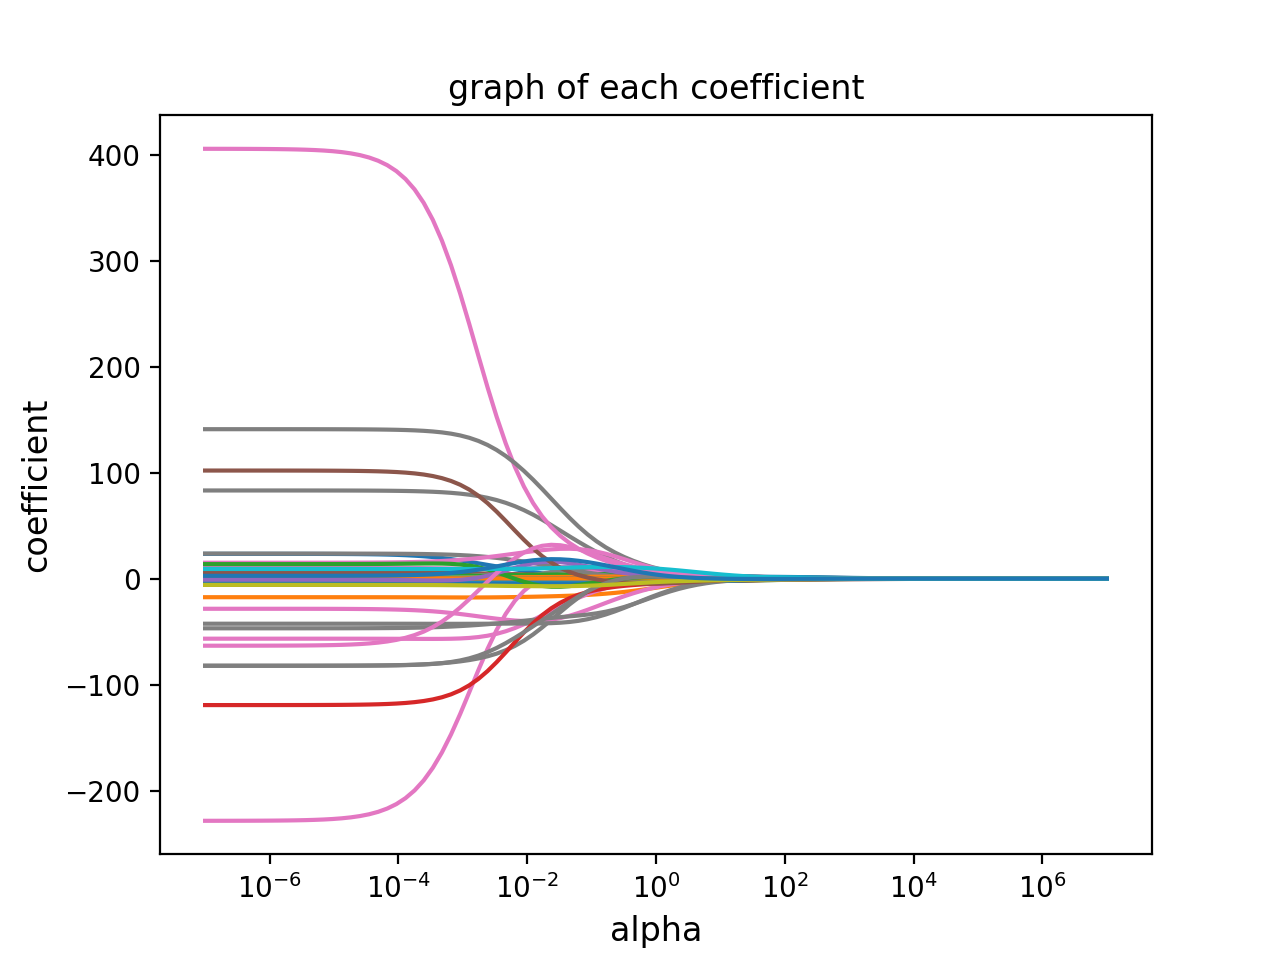

In [348]:
# ADD YOUR CODE HERE
plt.title("graph of each coefficient", fontsize=12)  #  title
plt.xlabel("alpha", fontsize=12)            #  x axis name
plt.ylabel("coefficient", fontsize=12)       #  y axis name

plt.xscale('log')  # scale to the log axis
for i in range(81):
    plt.plot(alphas, list_weights[i])
    

Why are the values of the weights largest on the left? Do they all change monotonically? 

1, Why are the values of the weights largest on the left? 
----The bigger the alpha is, the bigger the penalty term is. (the penalty term is the term with an identity matrix.)Then, each coefficient become close to zero. That's why the values of the weights are largest on the left.

2, Do they all change monotonically?
----No, each coefficiets is changing based on the alpha differently one another. Some coefficiets increase fast which means this increases at the point of 10^(-4) alpha. However some coefficients decrease later, which means this decreases at the point of 10^(-2) alpha.

Plot how the performance (i.e. the error) changes as a function of $\alpha$. Again, use appropriate scaling of the x-axis. As a sanity check, the MSE value for very small $\alpha$s should be close to the test-set MSE of the unregularized solution, i.e. 599.

<IPython.core.display.Javascript object>


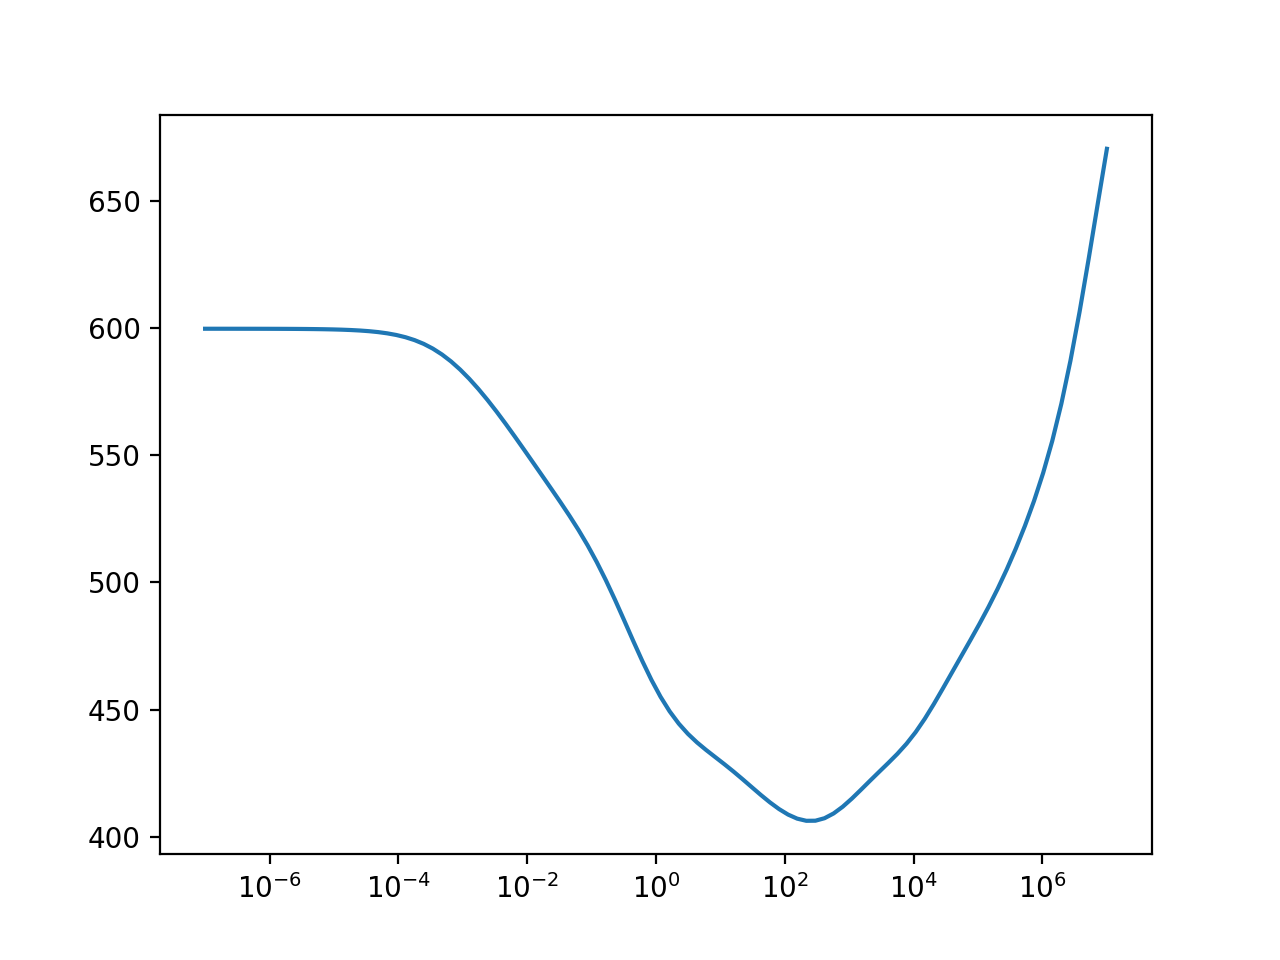

minimum MSE:  406.2638214316032
alpha which gives the minimum MSE: 215.44346900318777


In [349]:
# ADD YOUR CODE HERE
plt.xscale('log')
plt.plot(alphas, list_MSE)
plt.show()
print('minimum MSE: ', min(list_MSE)) # get the minimum of the MSE
print('alpha which gives the minimum MSE:', alphas[list_MSE.index(min(list_MSE))])  # get the alpha which minimumize the MSE

Which value of $\alpha$ gives the minimum MSE? Is it better than the unregularized model? Why should the curve reach ~600 on the left?

1, Which value of α gives the minimum MSE?
minimum MSE is 406.2638214316032 given by the alpha = 215.44346900318777.

2, Is it better than the unregularized model?
The MSE of the unregularized model is 599.7397626176332. Since the MSE of the regularized model is smaller than that of the unregularized model, the unregularized model is better.

3, Why should the curve reach ~600 on the left?
This is because the alpha on the left is very small, then the penalty term of the ridge regression model becomes almost zero. This means the the ridge regression model with the very small regularization parameter (alpha) is almost same as the unregularized model. When the alpha is bery small, the MSE of the ridge regression model should become close the MSE of the unreguralized model. MSE 600 on the left of the plot is almost corresponding to the MSE ofthe unreguralized model. Thus the curve reaches 600 on the left. 

Now implement the same model using sklearn. Use the `linear_model.Ridge` object to do so.


In [350]:
from sklearn.linear_model import Ridge
def ridge_regression_sklearn(X_test, X_train, y_train,alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha using the sklearn
       library on the training set and returns weights and testset predictions.
    
       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set 
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength
         
       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set
          
       Note:
         The sklearn library automatically takes care of adding a column for the offset.     
   
    
    '''
    
    # ADD YOUR CODE HERE
    clf = Ridge(alpha=alpha)
    reg = clf.fit(X_train, y_train) 
    weights = np.append(clf.intercept_, clf.coef_) # to consider the intercept part of the estimated weights.
    y_pred = clf.predict(X_test) 
    
    return weights, y_pred

<IPython.core.display.Javascript object>


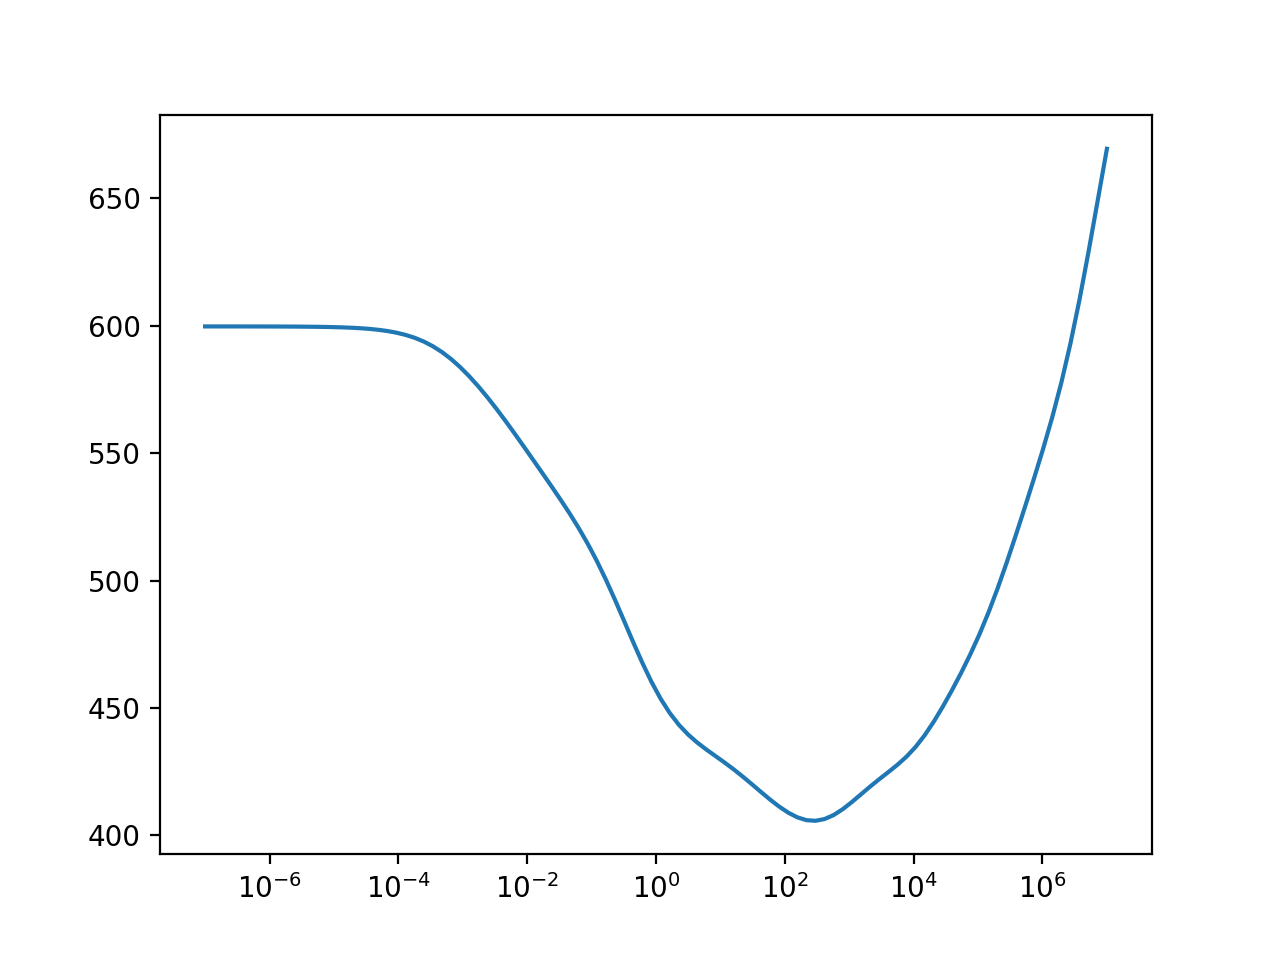

minimum MSE:  405.6778354209982
alpha which gives the minimum MSE: 298.3647240283334


In [351]:
list_MSE = [] # make an empty list

for i, alpha in enumerate(alphas):
    weights, y_pred = ridge_regression_sklearn(X_test, X_train, y_train, alpha)
    MSE = mean_squared_error(y_test,y_pred)
    list_MSE.append(MSE) #add the MES which we abtain in i-th iteration

plt.xscale('log')
plt.plot(alphas, list_MSE)
plt.show()
# get the minimum of the MSE
print('minimum MSE: ', min(list_MSE)) 
# get the alpha which minimumize the MSE
print('alpha which gives the minimum MSE:', alphas[list_MSE.index(min(list_MSE))])  

This time, only plot how the performance changes as a function of $\alpha$. 

Note: Don't worry if the curve is not exactly identical to the one you got above. The loss function we wrote down in the lecture  has $\alpha$ defined a bit differently compared to sklearn. However, qualitatively it should look the same.

## Task 5: Cross-validation [15 pts]

Until now, we always estimated the error on the test set directly. However, we typically do not want to tune hyperparameters of our inference algorithms like $\alpha$ on the test set, as this may lead to overfitting. Therefore, we tune them on the training set using cross-validation. As discussed in the lecture, the training data is here split in `n_folds`-ways, where each of the folds serves as a held-out dataset in turn and the model is always trained on the remaining data. Implement a function that performs cross-validation for the ridge regression parameter $\alpha$. You can reuse functions written above.

In [352]:
#define the function which returns the separated arrays by following the cross validation methods.
def train_test(x, y, n_folds, r):
    np.random.seed(seed=2) #make random seeds
    perm_idx = np.random.permutation(np.arange(len(y))) #make the whole index of X and y
    folds = np.array_split(perm_idx, n_folds) #devide the whole index into n_folds folds
    idx_test =  folds[r].astype(int) #one of the folds is assigned to the test set's index
    folds_copy = np.copy(folds)  #make a copy of the whole index
    idx_train_pre = np.delete(folds_copy, r, 0) #delete the test set's index
    empty = []
    i=0
    #make one list of index for train sets
    while i <(n_folds-1):
        empty = np.hstack(([empty, idx_train_pre[i]]))
        i+=1
    idx_train = empty.astype(int) #one list made above is assigned to the train set's index
    X_test_dev = x[idx_test] #make a test set using the index
    X_train_dev = x[idx_train] #make train sets using the index
    y_test_dev = y[idx_test]
    y_train_dev = y[idx_train] #make train sets using the index
    return X_train_dev, X_test_dev, y_train_dev, y_test_dev

In [353]:
def ridgeCV(X, y, n_folds, alphas):
    '''Runs a n_fold-crossvalidation over the ridge regression parameter alpha. 
       The function should train the linear regression model for each fold on all values of alpha.
    
      Inputs: 
        X: (n_obs, n_features) numpy array - predictor
        y: (n_obs,) numpy array - target
        n_folds: integer - number of CV folds
        alphas: (n_parameters,) - regularization strength parameters to CV over
        
      Outputs:
        cv_results_mse: (n_folds, len(alphas)) numpy array, MSE for each cross-validation fold 
        
      Note: 
        Fix the seed for reproducibility.
        
        '''    
    
    cv_results_mse = np.zeros((n_folds, len(alphas)))
                                     
    for r in range(n_folds):
        X_train_dev, X_test_dev, y_train_dev, y_test_dev = train_test(X, y, n_folds, r)
        #reshape these arrays
        X_train_dev = np.reshape(X_train_dev, [-1, 81])
        X_test_dev = X_test_dev.reshape((X_test_dev.shape[0], -1))
        y_train_dev = np.reshape(y_train_dev, [-1, 1])
        y_test_dev = y_test_dev.reshape((y_test_dev.shape[0], -1))
        #calculate each MSE as changing alphas
        for i, alpha in enumerate(alphas):
            weights, y_pred_dev = ridge_regression_sklearn(X_test_dev, X_train_dev, y_train_dev, alpha)
            MSE = mean_squared_error(y_test_dev,y_pred_dev)
            cv_results_mse[r][i] = MSE
            
    return cv_results_mse  

Now we run 10-fold cross-validation using the training data of a range of $\alpha$s.

In [354]:
alphas = np.logspace(-7,7,100)
mse_cv = ridgeCV(X_train, y_train, n_folds=10, alphas=alphas)

We plot the MSE trace for each fold separately:

<IPython.core.display.Javascript object>


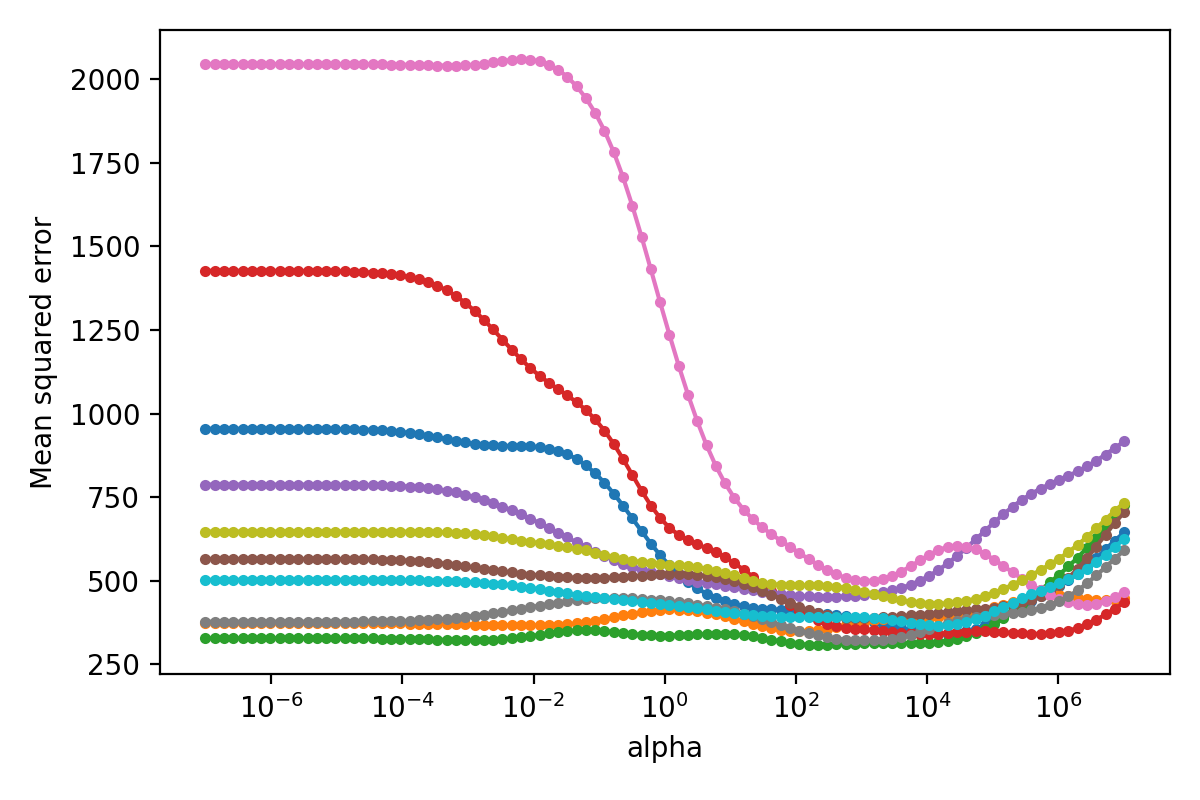

In [355]:
plt.figure(figsize=(6,4))
plt.plot(alphas, mse_cv.T, '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We also plot the average across folds:

<IPython.core.display.Javascript object>


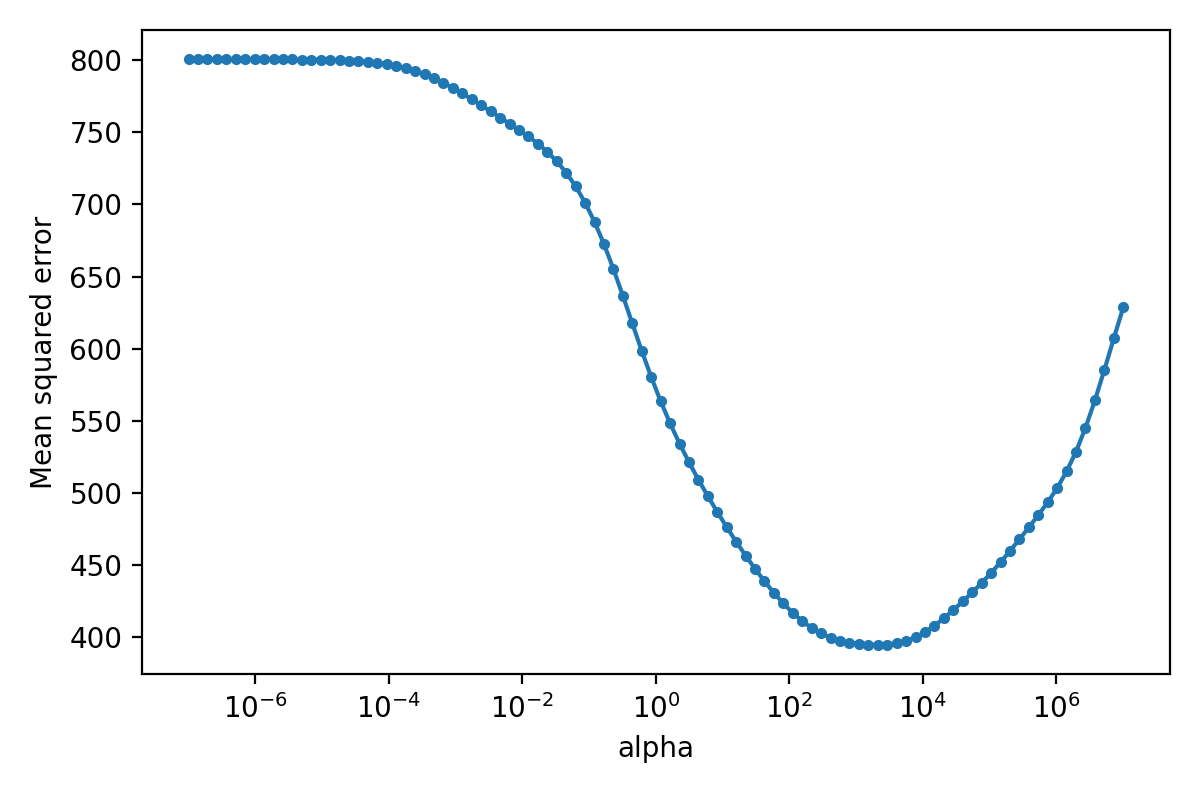

minimum MSE:  394.4956322468321
alpha which gives the minimum MSE: 2104.904144512022


In [356]:
plt.figure(figsize=(6,4))
plt.plot(alphas, np.mean(mse_cv,axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()
mean_MSE = np.mean(mse_cv,axis=0)
mean_MSE = mean_MSE.tolist()
# get the minimum of the MSE
print('minimum MSE: ', min(mean_MSE)) 
# get the alpha which minimumize the MSE
print('alpha which gives the minimum MSE:', alphas[mean_MSE.index(min(mean_MSE))])  

What is the optimal $\alpha$? Is it similar to the one found on the test set? Do the cross-validation MSE and the test-set MSE match well or differ strongly?

1, What is the optimal α ? 
optimal alpha is 2104.904144512022 which gives the minimum MSE: 394.4956322468321.

2, Is it similar to the one found on the test set? 
It is quite similar to the one found on the test set, but these shapes are a bit different from each other. The plot of the cross-validation MSE is more smooth than one found on the test set. I guess this is because we take the mean of MSE of all times of the cross-validation.

3, Do the cross-validation MSE and the test-set MSE match well or differ strongly?
Test-set MSE was 405.6778354209982. Cross-validation MSE is quite close to the Test-set MSE, but Cross-validation MSE is slight smaller. 

We will now run cross-validation on the full training data. This will take a moment, depending on the speed of your computer. Afterwards, we will again plot the mean CV curves for the full data set (blue) and the small data set (orange).

In [357]:
alphas = np.logspace(-7,7,100)
mse_cv_full = ridgeCV(X_train_full, y_train_full, n_folds=10, alphas=alphas)




/Users/oomuranatsumi/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:793: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/Users/oomuranatsumi/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:793: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
/Users/oomuranatsumi/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:793: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequenc

<IPython.core.display.Javascript object>


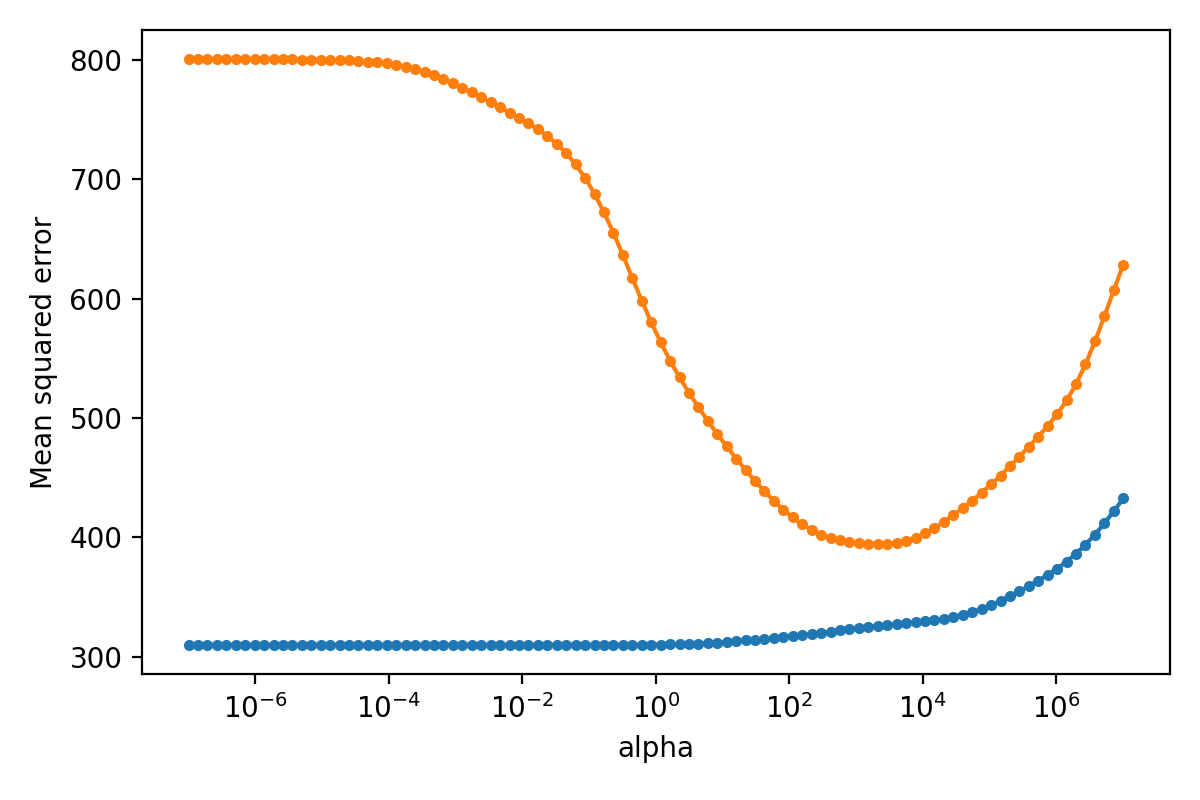

In [358]:
plt.figure(figsize=(6,4))
plt.plot(alphas, np.mean(mse_cv_full,axis=0), '.-')
plt.plot(alphas, np.mean(mse_cv,axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We determine the (very subtle) minimum of the blue curve and zoom in around it to be able to see it:

<IPython.core.display.Javascript object>


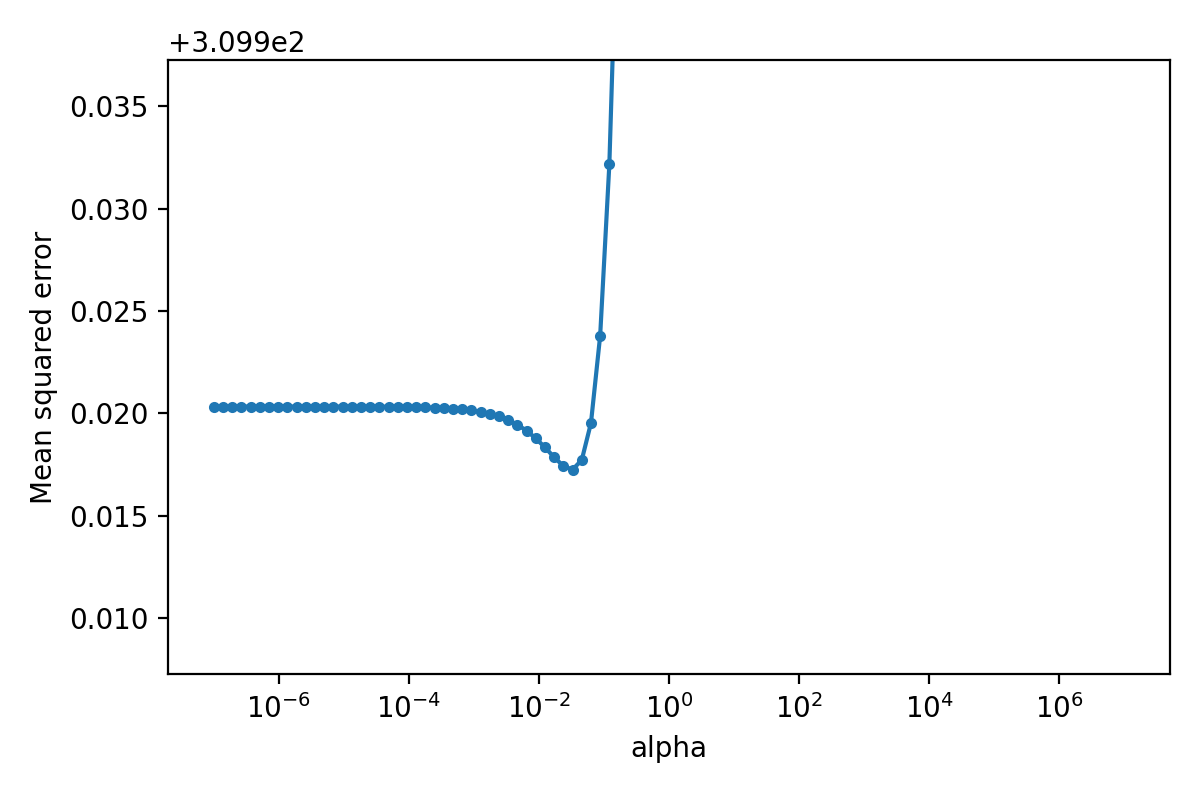

minimum MSE:  309.91724321995883
alpha which gives the minimum MSE: 0.03274549162877725


In [359]:
plt.figure(figsize=(6,4))
plt.plot(alphas, np.mean(mse_cv_full,axis=0), '.-')
plt.xscale('log')
minValue = np.min(np.mean(mse_cv_full,axis=0))
plt.ylim([minValue-.01, minValue+.02])
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

mean_MSE = np.mean(mse_cv_full,axis=0)
mean_MSE = mean_MSE.tolist()
# get the minimum of the MSE
print('minimum MSE: ', min(mean_MSE)) 
# get the alpha which minimumize the MSE
print('alpha which gives the minimum MSE:', alphas[mean_MSE.index(min(mean_MSE))])  


Why does the CV curve on the full data set look so different? What is the optimal value of $\alpha$ and why is it so much smaller than on the small training set?

1, Why does the CV curve on the full data set look so different? 

The first typical character of this graph is MSE. MSE of the small test set cross validation was 394.4956322468321. MSE of the small test set cross validation was 394.4956322468321, this is smaller. I guess that is because the number of the full training set is 10 times larger than the number of small full training set, then it can be considered that the fitting of the model on the full training set has becom better.

The second typical character of this graph is the shape. MSEs of the left side are largely different from each other. I guess this reason is that the model on full test set fits greatly even if the penalty term (alpha * identity matrix) is not influencial. 

2, What is the optimal value of α?

alpha which gives the minimum MSE: 0.03274549162877725

3, Why is the optimal value of α so much smaller than on the small training set?

Alpha is the regularization parameter which controls the penalty term. As I mentioned on the first question, the model on full test set fits greatly even if the penalty term (alpha * identity matrix) is not influencial. Thus the optimal value of α is much smaller than on the small training set.